<a href="https://colab.research.google.com/github/kevinmfreire/sentiment-analysis/blob/main/tweet_dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Dataset Analysis

## First let's download datasets from google drive to google collab.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!cp -r /gdrive/MyDrive/SharpestMinds/datasets/ /content/

##Now that we have our dataset, we have three objectives: 
* Understand the dataset and clean it up
* Build a classification model to predict the twitter sentiment
* Compare the evalutation metrics of a few classification algorithms

We first want to import our libraries

In [3]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
import math

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,RandomizedSearchCV,RepeatedStratifiedKFold,GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score,roc_auc_score, roc_curve, precision_score, recall_score
from scikitplot.metrics import plot_roc_curve as auc_roc

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

# Dwnloading NLTK packages
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Data Exploration

In [15]:
# Load dataset then check columns and values
tweet_df = pd.read_csv('./datasets/twitter-tweets-sentiment-dataset/Tweets.csv', header=0)
tweet_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


* Let's check additional information on dataset

In [16]:
tweet_df.describe(include='O')

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


* We do not need the date, ids, flag or user, I will drop those columns and keepy sentiment and text.

In [17]:
# Dropping the twitter-tweets dataset
tweet_df.drop(['selected_text', 'textID'], axis=1, inplace=True)
tweet_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


* The Kaggle Sentiment140 dataset has values 0=negative and 4=positive.
* I will replace all values with -1=negative and 1=positive.

In [ ]:
to_sentiment = {0: "negative", 4: "positive"}
def label_decoder(label):
    return to_sentiment[label]

tweet_df.sentiment = tweet_df.sentiment.apply(lambda x: label_decoder(x))
tweet_df.head()

,sentiment,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."


* I create a target value to select the column 'sentiment'
* Then I copy the dataset as original_df

In [18]:
target = 'sentiment'
original_df = tweet_df.copy(deep=True)

In [19]:
print('\n\033[1mData Dimension:\033[0m Dataset consists of {} columns & {} records.'.format(tweet_df.shape[1], tweet_df.shape[0]))


Data Dimension: Dataset consists of 2 columns & 27481 records.


In [20]:
# Let's check the dtypes of all columns

tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [21]:
# Checking the stats of all the columns

tweet_df.describe()

,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


# Data Processing

In [22]:
# Check for empty elements

tweet_df.isnull().sum()

text         1
sentiment    0
dtype: int64

In [23]:
# Remove any missing values
# rom the above cell there are no missing values so we do not run this cell

tweet_df.dropna(inplace=True)
original_df = tweet_df.copy(deep=True)

In [24]:
tweet_df[tweet_df.duplicated()]

,text,sentiment


In [25]:
# Let's remove duplicated rows (if any)

counter = 0
r, c = original_df.shape

tweet_df_dedup = tweet_df.drop_duplicates()
tweet_df_dedup.reset_index(drop=True, inplace=True)

if tweet_df_dedup.shape==(r,c):
  print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
  print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {r-tweet_df_dedup.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [26]:
tweet_df_dedup.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


With computational complexity I will reduce the data by a scale of 4 so the text pre-processing will not take too long and once we have a baseline model I will then train the model with the entire dataset.

In [ ]:
def split_data(data, scale):
  neg_df = data[data['sentiment']=='negative']
  pos_df = data[data['sentiment']=='positive']
  neg_df = neg_df[0:(len(neg_df)//scale)]
  pos_df = pos_df[0:(len(pos_df)//scale)]
  new_df = [neg_df, pos_df]
  new_df = pd.concat(new_df)
  return new_df

new_df_split = split_data(tweet_df_dedup, 4)
new_df_split.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395922 entries, 0 to 988560
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  395922 non-null  object
 1   text       395922 non-null  object
dtypes: object(2)
memory usage: 9.1+ MB


## Let's do some basic text processing such as:
* Convert to lower case
* Tokenisation
* Remove puntuation
* Remove stop words
* Stemming
* Lemmatization

In [27]:
# Cleaning the text
tweet_df_clean = tweet_df_dedup.copy()

def preprocessor(text):
  text = re.sub('[^a-zA-Z]',' ', text)    # remove punctuation
  text = text.lower()                     # convert to lowercase
  text = text.strip()                     # remove leading and tailing whitespaces
  # Stemming
  text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
  text = ' '.join([word for word in text.split() if word.isalnum()])  
  text = ' '.join([WordNetLemmatizer().lemmatize(word,pos='v') for word in text.split()]) 
  text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
  return text

In [28]:
tweet_df_clean['text'] = tweet_df_dedup['text'].apply(preprocessor)
tweet_df_clean.head()

,text,sentiment
0,respond go,neutral
1,sooo sad miss san diego,negative
2,boss bully,negative
3,interview leave alone,negative
4,sons put release already buy,negative


**Inference:** The text is now clean from the removal of all punctuations, stop words and stemming.

* We next want to tokenize our dataset using Porter Stemmer

In [29]:
porter = PorterStemmer()

def tokenizer_porter(text):
  return [porter.stem(word) for word in text.split()]

Let's extract features using TF-IDF

In [30]:
tf_idf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None, tokenizer=tokenizer_porter, use_idf=True, norm='l2', smooth_idf=True)
label=tweet_df_clean[target].values
features=tf_idf.fit_transform(tweet_df_clean.text)

Let's look at the labels

In [31]:
label

array(['neutral', 'negative', 'negative', ..., 'positive', 'positive',
       'neutral'], dtype=object)

Now let's look at the features

In [32]:
features

<27480x19389 sparse matrix of type '<class 'numpy.float64'>'
	with 191163 stored elements in Compressed Sparse Row format>

## Exploratory Data Analysis (EDA)

            Target Variable Distribution           


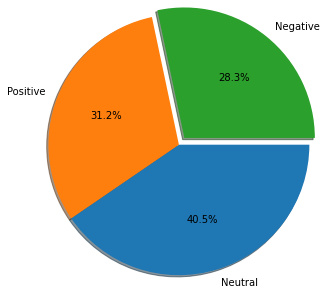

In [34]:
# Let'sanalyze the distribution oof the target values
print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(tweet_df_clean[target].value_counts(), labels=['Neutral','Positive','Negative'], counterclock=False, shadow=True, 
        explode=[0,0,0.1], autopct='%1.1f%%', radius=1.5, startangle=0)
plt.show()

Both the Negative and Positive values seem to be about the same.

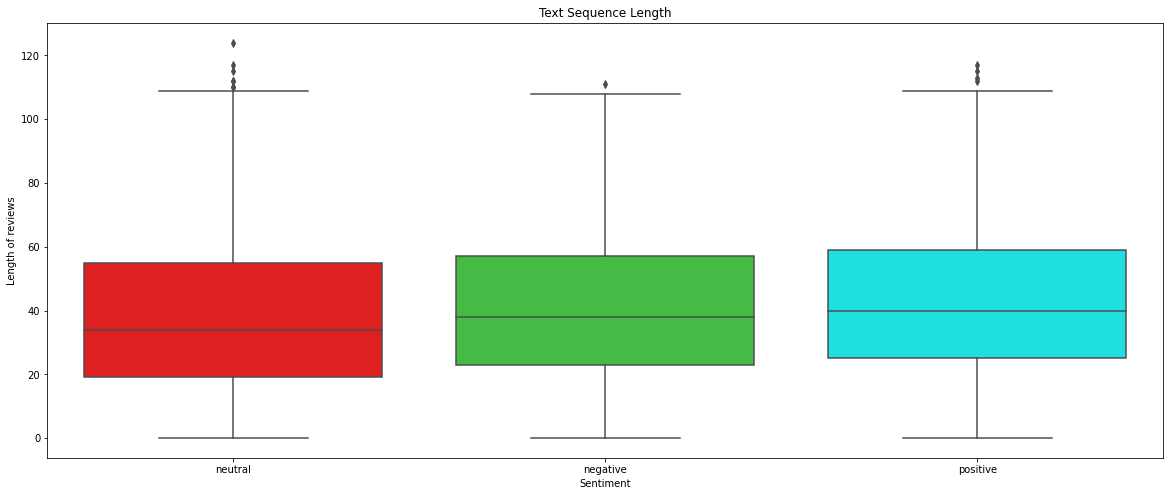

In [35]:
# Visualizing the average text sequence length

tweet_df_rl = tweet_df_clean.copy()
tweet_df_rl['review_length'] = 0

tweet_df_rl['review_length'] = tweet_df_rl['text'].apply(lambda x:len(x))

plt.figure(figsize=[20,8])
sns.boxplot(x=label, y='review_length', data=tweet_df_rl, palette=['red', 'limegreen','cyan'])
plt.title('Text Sequence Length')
plt.xlabel("Sentiment")
plt.ylabel("Length of reviews")
plt.show()

**The sequence length for reviews on an average are almost similar for both positive and negative tweets**

* Let's compare with the original tweet dataframe we save earlier

In [36]:
# original_df = new_df_split.copy()
neut_df = original_df[original_df[target]=='neutral']['text']
pos_df = original_df[original_df[target]=='positive']['text']
neg_df = original_df[original_df[target]=='negative']['text']

In [37]:
def freq_text(text_df):
  combi_text=""
  for x in text_df.values:
    combi_text+=' '.join(x.split())
  combi_text = [x for x in combi_text.split() if len(x) >3 and x not in stopwords.words('english')]
  return combi_text

In [38]:
def freq_df(text_count_df, senti):
  fredis=nltk.FreqDist(text_count_df)
  fredis_df = pd.DataFrame({senti: list(fredis.keys()), 'Count': list(fredis.values())})
  fredis_df = fredis_df.sort_values(by='Count', ascending=False)
  return fredis_df

In [39]:
def plot_freq_dis(text_count_df,senti):
  sns.barplot(data=text_count_df[:10], x=senti, y='Count')

In [40]:
pos_df.shape

(8582,)

In [41]:
pos_df = pos_df.apply(preprocessor)

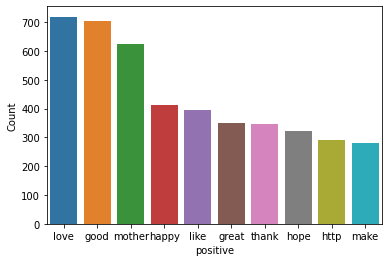

In [42]:
senti = 'positive'
pos_text = freq_text(pos_df)
pos_freq_df = freq_df(pos_text,senti)
plot_freq_dis(pos_freq_df,senti)

In [43]:
neg_df.shape

(7781,)

In [44]:
neg_df = neg_df.apply(preprocessor)

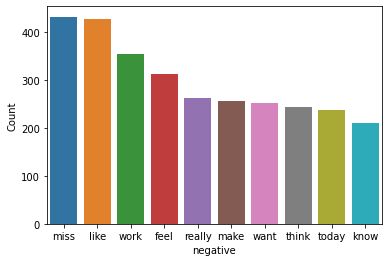

In [45]:
senti='negative'
neg_text = freq_text(neg_df)
neg_freq_df = freq_df(neg_text, senti)
plot_freq_dis(neg_freq_df, senti)

In [46]:
neut_df.shape

(11117,)

In [47]:
neut_df = neut_df.apply(preprocessor)

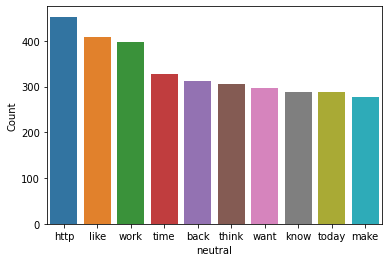

In [51]:
senti='neutral'
neut_text = freq_text(neut_df)
neut_freq_df = freq_df(neut_text, senti)
plot_freq_dis(neut_freq_df, senti)

In [52]:
def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

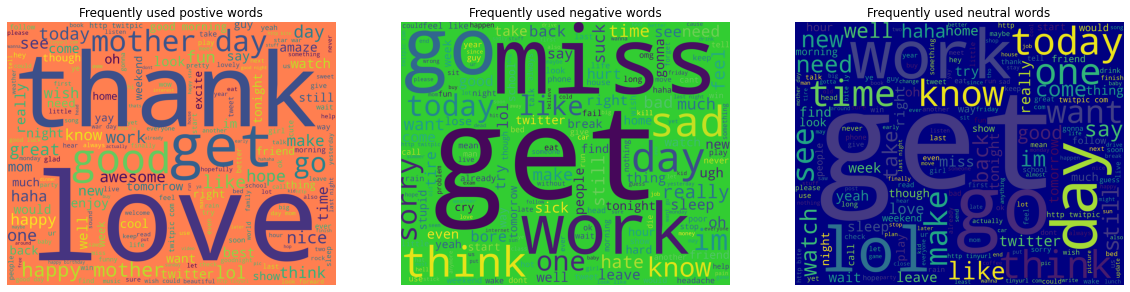

In [53]:
plt.figure(figsize=[20,10])
plt.subplot(1,3,1)
wordcloud_draw(pos_df,'coral','Frequently used postive words')
plt.subplot(1,3,2)
wordcloud_draw(neg_df, 'limegreen','Frequently used negative words')
plt.subplot(1,3,3)
wordcloud_draw(neut_df, 'navy','Frequently used neutral words')
plt.show()

# Predictive Modeling

Let's begin a simple training

In [54]:
#  Assigning labels to target variable

label_mapping = {'negative':0, 'neutral':1, 'positive':2}
tweet_df_clean['sentiment'] = tweet_df_clean['sentiment'].map(label_mapping)

In [55]:
# Split data into training and testing sets

X = features
y = pd.Series(label).map(label_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('Original set  ---> ','feature size: ',X.shape,'label size',len(y))
print('Training set  ---> ','feature size: ',X_train.shape,'label size',len(y_train))
print('Test set  --->  ','feature size: ',X_test.shape,'label size',len(y_test))

Original set  --->  feature size:  (27480, 19389) label size 27480
Training set  --->  feature size:  (21984, 19389) label size 21984
Test set  --->   feature size:  (5496, 19389) label size 5496


In [56]:
# Let's create a table to store the results of various models

result_df = pd.DataFrame(columns=['Models','Accuracy','Precision','Recall','F1-score','AUC-ROC score'])
result_df['Models']=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naive Bayes Classifier (NB)']
result_df.fillna(0.0,inplace=True)
result_df.set_index('Models',inplace=True)
result_df

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Models,,,,,
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naive Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


In [57]:
result_df.loc['Logistic Regression (LR)','Accuracy']

0.0

In [63]:
# Classification Summary Function
def classification_summary(pred,pred_prob,model):
  result_df.loc[model,'Accuracy']   =round(accuracy_score(y_test,pred),3)*100   
  result_df.loc[model,'Precision']=round(precision_score(y_test, pred, average='weighted'),3)*100
  result_df.loc[model,'Recall']=round(recall_score(y_test, pred, average='weighted'),3)*100
  result_df.loc[model,'F1-score']=round(f1_score(y_test, pred, average='weighted'),3)*100
  result_df.loc[model,'AUC-ROC score']=round(roc_auc_score(y_test, pred_prob, multi_class='ovr'),3)*100

  print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,model, '-'*35,'>'*3))
  print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred),3)*100))
  print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'),3)*100))
  print('Precision Score = {}%'.format(round(precision_score(y_test, pred, average='weighted'),3)*100))
  print('Recall Score = {}%'.format(round(recall_score(y_test, pred, average='weighted'),3)*100))
  print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(y_test, pred))
  print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))

  auc_roc(y_test, pred_prob, curves=['each_class'])
  plt.show()

In [64]:
  # Visualizing Function
  def auc_roc_plot(y_test,pred):
    ref = [0 for _ in range(len(y_test))]
    ref_auc = roc_auc_score(y_test,ref)
    lr_auc = roc_auc_score(y_test, pred)

    ns_fpr, ns_tpr, _ = roc_curve(y_test,ref)
    lr_fpr, lr_tpr, _ = roc_curve(y_test,pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='=')
    plt.plot(lr_fpr, lr_tpr, marker='*', label='AUC = {}'.format(round(roc_auc_score(y_test,pred)*100,2)))
    plt.xlabel('Flase Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## 1. Logistic Regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 69.1%
F1 Score = 69.0%
Precision Score = 70.19999999999999%
Recall Score = 69.1%

 Confusiton Matrix:
 [[ 884  536  103]
 [ 250 1761  264]
 [  53  494 1151]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.58      0.65      1523
           1       0.63      0.77      0.70      2275
           2       0.76      0.68      0.72      1698

    accuracy                           0.69      5496
   macro avg       0.71      0.68      0.69      5496
weighted avg       0.70      0.69      0.69      5496



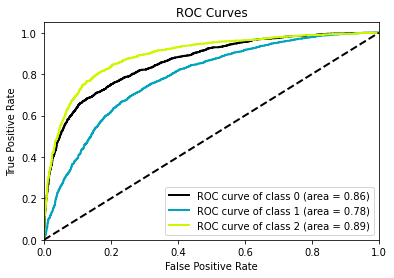

In [65]:
# Building Logistic Regression Classifier

log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)
pred = log_reg_model.predict(X_test)
pred_prob = log_reg_model.predict_proba(X_test)
classification_summary(pred,pred_prob,'Logistic Regression (LR)')

## 2. Decision Tree Classifier

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 65.60000000000001%
F1 Score = 65.60000000000001%
Precision Score = 65.60000000000001%
Recall Score = 65.60000000000001%

 Confusiton Matrix:
 [[ 933  427  163]
 [ 435 1477  363]
 [ 124  377 1197]]

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.61      0.62      1523
           1       0.65      0.65      0.65      2275
           2       0.69      0.70      0.70      1698

    accuracy                           0.66      5496
   macro avg       0.66      0.66      0.66      5496
weighted avg       0.66      0.66      0.66      5496



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


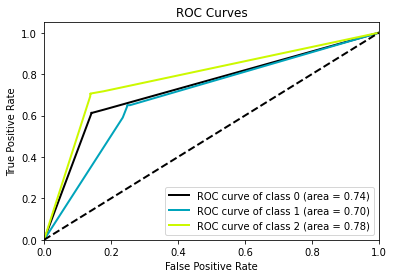

In [66]:
# Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()
DT_model.fit(X_train, y_train)
pred = DT_model.predict(X_test)
pred_prob = DT_model.predict_proba(X_test)
classification_summary(pred,pred_prob,'Decision Tree Classifier (DT)')

## 3. Random Forest Classifier:

<<<----------------------------------- Evaluating Random Forrest Classifier (RF) ----------------------------------->>>

Accuracy = 69.8%
F1 Score = 69.6%
Precision Score = 70.19999999999999%
Recall Score = 69.8%

 Confusiton Matrix:
 [[ 883  508  132]
 [ 255 1694  326]
 [  60  380 1258]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.58      0.65      1523
           1       0.66      0.74      0.70      2275
           2       0.73      0.74      0.74      1698

    accuracy                           0.70      5496
   macro avg       0.71      0.69      0.69      5496
weighted avg       0.70      0.70      0.70      5496



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


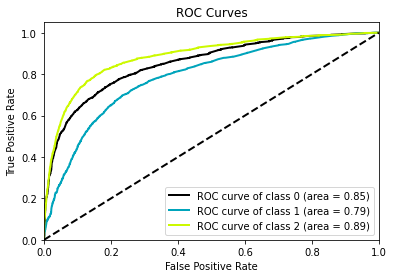

In [67]:
# Building Forrest Classifier

RF_model = RandomForestClassifier()
RF_model.fit(X_train,y_train)
pred = RF_model.predict(X_test)
pred_prob = RF_model.predict_proba(X_test)
classification_summary(pred, pred_prob, 'Random Forrest Classifier (RF)')

## 4. Naive Bayes Classifier

<<<----------------------------------- Evaluating Naive Bayes Classifier (NB ----------------------------------->>>

Accuracy = 64.0%
F1 Score = 63.6%
Precision Score = 66.0%
Recall Score = 64.0%

 Confusiton Matrix:
 [[ 714  712   97]
 [ 235 1757  283]
 [  65  585 1048]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.47      0.56      1523
           1       0.58      0.77      0.66      2275
           2       0.73      0.62      0.67      1698

    accuracy                           0.64      5496
   macro avg       0.67      0.62      0.63      5496
weighted avg       0.66      0.64      0.64      5496



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


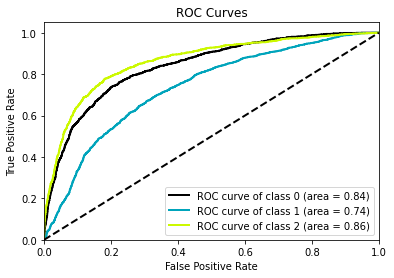

In [68]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()
NB_model.fit(X_train,y_train)
pred = NB_model.predict(X_test)
pred_prob = NB_model.predict_proba(X_test)
classification_summary(pred,pred_prob,'Naive Bayes Classifier (NB')

## Comparing all the models

In [69]:
# Plotting Confusion-Matrix of all predictive Models

labels=['Positive','Negative']
def plot_cm(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
  cm_sum = np.sum(cm, axis=1, keepdims=True)
  cm_prec = cm / cm_sum.astype(float) * 100
  annot = np.empty_like(cm).astype(str)
  nrows, ncols = cm.shape
  for i in range(nrows):
    for j in range(ncols):
      c = cm[i,j]
      p = cm_prec[i,j]
      if i==j:
        s = cm_sum[i]
        annot[i,j] = '%.1f%%\n%d/%d' % (p,c,s)
      elif c==0:
        annot[i,j] = ''
      else:
        annot[i,j] = '%.1f%%\n%d' % (p,c)
  cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
  cm.columns=labels
  cm.index=labels
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  sns.heatmap(cm, annot=annot, fmt='')

In [70]:
def conf_mat_plot(all_models):
  plt.figure(figsize=[20,3*math.ceil(1+len([all_models])/4)])

  for i in range(len(all_models)):
    if len(labels)<=4:
      plt.subplot(1,4,i+1)
    else:
      plt.subplot(math.ceil(len(all_models)/2),2,i+1)
    pred = all_models[i].predict(X_test)
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='.0f')
    plt.title(result_df.index[i])
    plt.yticks([0,1,2],labels=['Predicted Negative','Predicted Netural','Predicted Positive'],rotation=45)
    plt.xticks([0,1,2],labels=['Actual Negative','Actual Netural','Actual Positive'],rotation=45)
  plt.tight_layout()
  plt.show()

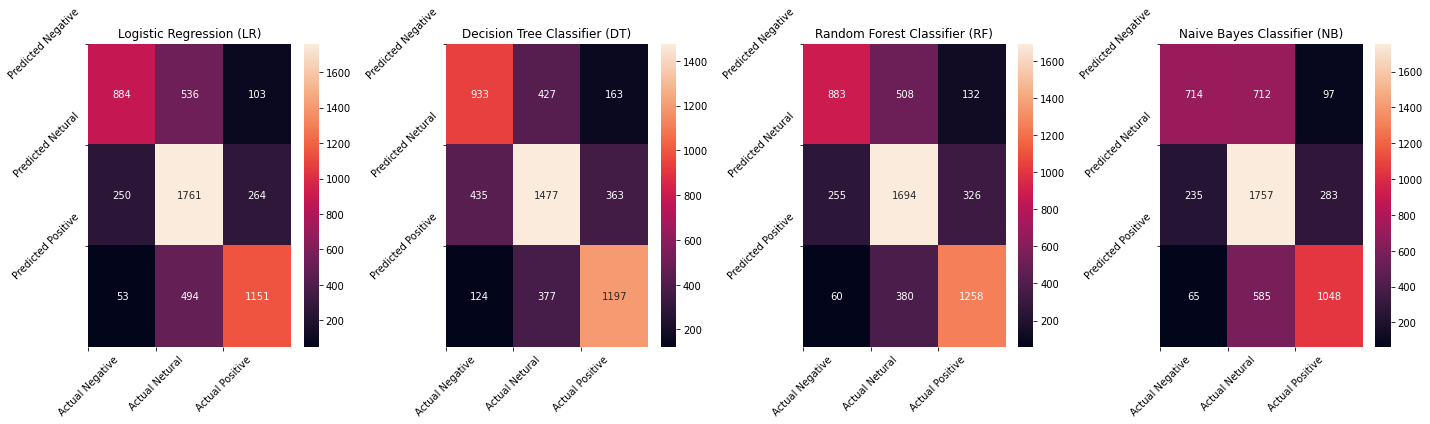

In [71]:
conf_mat_plot([log_reg_model, DT_model, RF_model, NB_model])

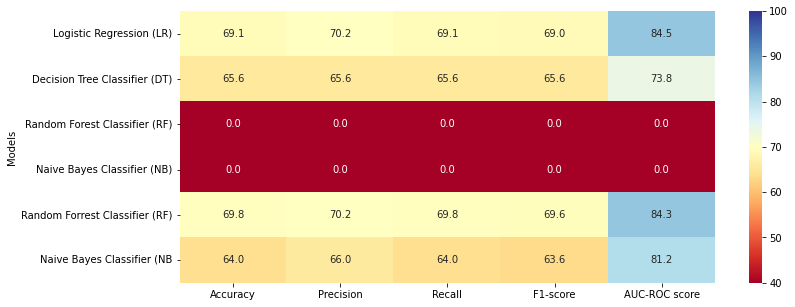

In [72]:
# Camparing all the models score

plt.figure(figsize=[12,5])
sns.heatmap(result_df, annot=True, vmin=40, vmax=100.0, cmap='RdYlBu', fmt='.1f')
plt.show()

In evaluating there are a  few  metrics we can use to measure performance:

* **Accuracy:** The ratio of he number of correct predictions and te al number of predictions.
* **Precision:** The number of ue positives over the number of predicted positives.
* **Recall:** The number of true positives over the total number of actual positives.
* **F1-Score:** The harmonic mean of precision and recall.

Since F1-Score is the combined idea between **Precision** and **Recall** then I will focus on the F1-Score of the Random Forest classifier since it performs best on the current dataset.  Performance can be incresed using hyperparametr tuning.  Let's try some random values for some of the parameters.

In [73]:
param_grid = {
    'n_estimators': [100,200,300,400],
    'max_features': ['sqrt','log2'],
    'max_depth': [1,2,4,5,6,7,8],
    'criterion': ['gini','entropy']
}

In [74]:
CV_rfc = GridSearchCV(estimator=RF_model, param_grid=param_grid, cv=5,n_jobs=-1)
CV_rfc.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400]})

In [76]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 300}

In [77]:
RF_model_cv=RandomForestClassifier(random_state=42,**CV_rfc.best_params_)
RF_model_cv.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt',
                       n_estimators=300, random_state=42)

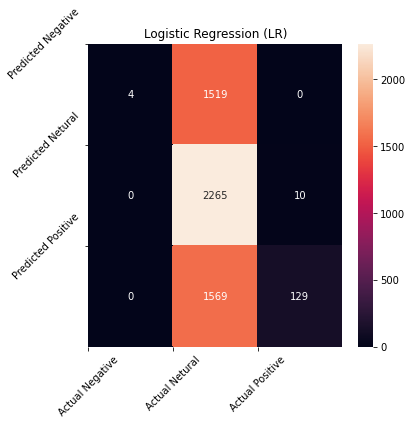

In [78]:
conf_mat_plot([RF_model_cv])

              precision    recall  f1-score   support

           0       1.00      0.00      0.01      1523
           1       0.42      1.00      0.59      2275
           2       0.93      0.08      0.14      1698

    accuracy                           0.44      5496
   macro avg       0.78      0.36      0.25      5496
weighted avg       0.74      0.44      0.29      5496

81.89999999999999


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


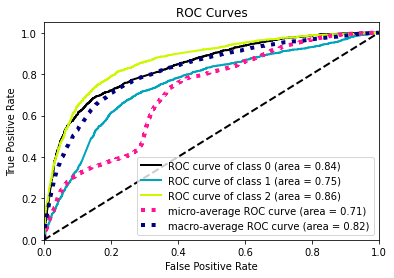

In [80]:
pred = RF_model_cv.predict(X_test)
pred_prob = RF_model_cv.predict_proba(X_test)
print(classification_report(y_test,pred))
accuracy_score(y_test,pred)
print(round(roc_auc_score(y_test, pred_prob, multi_class='ovr'),3)*100)
auc_roc(y_test,pred_prob)

# Conclusions

**From the above experimentation we can conclude that:**
* The Dataset consists of 27481 record.
* Basic preprocessing techniques help us to get rid of unwanted character and gave us the clean data.
* The labels in the target variable were somewhat uniformally distributed.
* Testing multiple algorithms with default settings .
* The performace of models were almost similar.
* Considering the all metrics, we see Random Forest Classifier performed the best on the current dataset.
* Being an equal contendor,it is wise to also consider simpler models like * Logisitic Regression as it is more generalisable & computationally less expensive.
* We tried to apply hyperparameter tuning on RandomForest but that let to degrade the performace, so one can say we can consider the random forest model with default settings.